# ODE  model of NeuroImaging with Bayesian Inference in Numpyro

:::

:post: April 12, 2024
:tags: ODE model in Nympyro
:category: Advanced, how-to
:authors: Meysam HASHEMI, Nina BLADY, INS, AMU, Marseille.
:acknowledgment: Cyprien DAUTREVAUX, Matthieu GILSON, and Marmadule WOODMAN. 

:::

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib
import pickle

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
import jax 
import jax.numpy as jnp
from jax import grad, vmap, lax, random
from jax.experimental.ode import odeint
from jax.lib import xla_bridge

In [3]:
import os
import multiprocessing

#set up for parallelizing the chains

def setup_parallelization():
    num_cores = multiprocessing.cpu_count()
    os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={num_cores}"
    jax.config.update("jax_enable_x64", True)
    jax.config.update("jax_platform_name", "cpu")
    print(f"Number of CPU cores: {num_cores}")
    print(f"Using devices: {jax.devices('cpu')}")

In [4]:
enable_parallelization = False

if enable_parallelization:
    setup_parallelization()
    print("Parallelizing chains.")
else:
    print("Skipping parallelization setup.")

Skipping parallelization setup.


In [5]:
import numpyro as npr
from numpyro import sample, plate, handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_value

In [6]:
npr.set_platform("cpu")

In [7]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.24.3
JAX version: 0.4.23
Numpyro version: 0.14.0
Arviz version: 0.17.1


In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [9]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [10]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver


output_dir= cwd + '/output_numpyro/'

try:
    os.makedirs(output_dir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## Purpose

The purpose of this notebook is to demonstrate how to perform Bayesian inference using Numpyro's NUTS on a system of ordinary differential equations (ODEs). For an example of ODEs in Numpyro, see ref [1]. The application is to model and fit neuroimaging data such as ERP/EEG/MEG recording (see Ref [2]).

The accuracy and efficiency of different samplers (gradient-free and gradient-based) have been compared in DCM Refs [3,4]. The conclusion is that gradient-free samplers are not powerful enough for this model, and HMC is state-of-the-art for sampling on such high-dimensional models with (nonlinear) correlated parameters. Here we benefit from automatic algorithms and automatic gradient calculation in PPLs such as Numpyro, especially with JAX's JIT acceleration. Nevertheless, multimodality is omnipresent for such high-dimensional parameters and nonlinear correlated parameters. 
   

### Key Conclusions

We propose solutions for convergence, such as increasing the max_tree_depth and decreasing target_accept_prob, to avoid issues with small step size. Remember that a smaller step size in HMC leads to heavier computational costs.

Importantly, we propose two main solutions to deal with multimodality:

    Initializing at the tail of the prior.

    Weighted stacking of the chains


In this notebook, we first run the NUTS with default values, then we use Weighted stacking to adress the multimodality. Finally we run the chains with initlization at the tail of prior, to reach convergence for all chains. 

Refs: 

1) https://num.pyro.ai/en/stable/examples/ode.html
    

2) https://www.sciencedirect.com/science/article/abs/pii/S1053811905008013


3) https://www.sciencedirect.com/science/article/pii/S1053811915001846


4) https://www.sciencedirect.com/science/article/pii/S1053811915006540


## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simuations in the repo. The neural mass model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

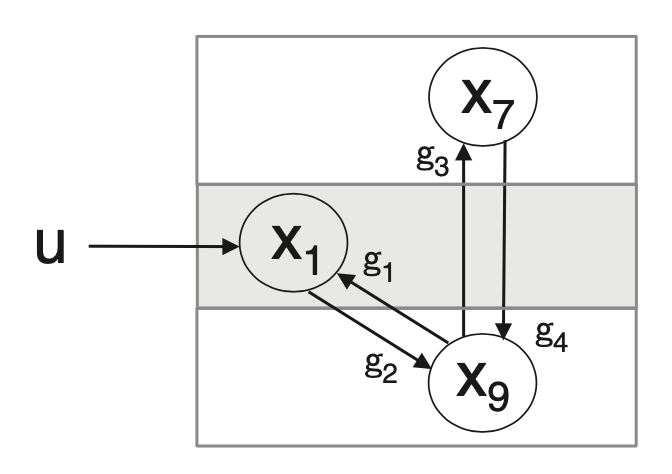

In [11]:
from IPython.display import Image
Image(filename='../Images/model.png', width=400)

This ODE given by:




\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}



The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

## Simulator

In [12]:
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler, odeint_heun, odeint_rk4

In [13]:
from jax import random
rng_key = random.PRNGKey(0)

In [14]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [15]:
ns = 9
x_init=np.zeros((ns))

In [16]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [17]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']
params_labels=['$g_1$', '$g_2$', '$g_3$', '$g_4$', '$\delta$', '$tau_i$', '$h_i$', '$tau_e$','$h_e$', '$u$']

Run the model

In [18]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 150 ms, sys: 11.3 ms, total: 161 ms
Wall time: 157 ms


In [19]:
%%time
xs_heun = odeint_heun(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 181 ms, sys: 8.69 ms, total: 190 ms
Wall time: 186 ms


In [20]:
%%time
xs_rk4 = odeint_rk4(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 294 ms, sys: 13.3 ms, total: 308 ms
Wall time: 303 ms


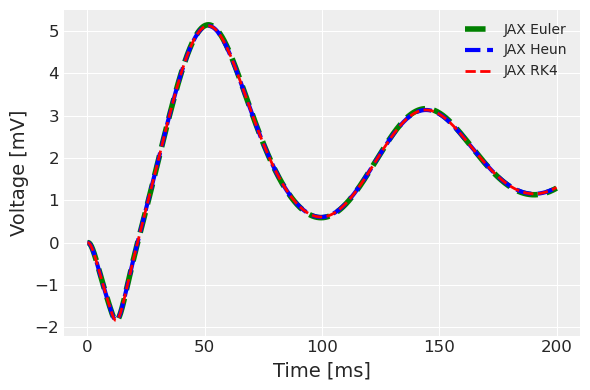

In [21]:
plt.figure(figsize=(6,4))
plt.plot(ts, xs_euler[:,8],'--', color='g', lw=4, label='JAX Euler');
plt.plot(ts, xs_heun[:,8],'--', color='b', lw=3, label='JAX Heun');
plt.plot(ts, xs_rk4[:,8],'--', color='r', lw=2, label='JAX RK4');
plt.legend(fontsize=10, frameon=False, loc='upper right')
plt.ylabel('Voltage [mV]', fontsize=14); 
plt.xlabel('Time [ms]', fontsize=14); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();
#plt.savefig(os.path.join((output_dir),"Simulators.png"), dpi=800)
plt.show()

So, we use Euler integration, But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [22]:
@jax.jit
def ERP_JAXOdeintSimuator(x_init, ts, params):
    
    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [23]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)


print("simulation with compiling took (sec):" , (time.time() - start_time))

simulation with compiling took (sec): 0.13758587837219238


In [24]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("simulation using JAX's JIT took (sec):" , (time.time() - start_time))

simulation using JAX's JIT took (sec): 0.000978231430053711


### Synthetic Observation

We assume that we only have accessto the activity of pyramidfal neurons, and for the sake of sppeding the computational time, we downsample the simuations.

In [25]:
#observation noise
sigma_true = 0.1 

In [26]:
xpy_jax = ERP_JAXOdeintSimuator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [27]:
#downsampling
ds=10

In [28]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [29]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [30]:
data= { 'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs }

In [31]:
from Helper.ERPhelper import *

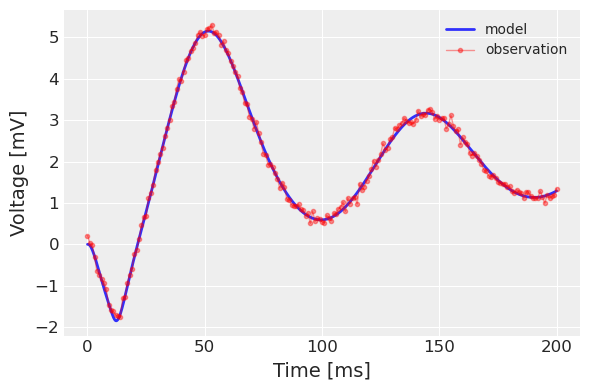

In [32]:
plot_observation(ts, xpy_jax, ts_obs, xpy_obs)

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].

In [33]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [34]:
prior_specs = dict(shape=shape, rate=rate)

In [35]:
def model(data, prior_specs):
    #Data
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    obs_err= data['obs_err']
    xpy_obs = data['xpy_obs']

    # Prior               
    g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
    g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
    delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
    tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
    h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
    tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
    h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
    u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))
     
    #Parameters    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    #Forward model
    xpy_hat=ERP_JAXOdeintSimuator(x_init, ts, params_samples)[::ds]
    
    # Likelihood
    with plate('data', size=nt_obs):
        xpy_model = npr.deterministic('xpy_model', xpy_hat)
        npr.sample('xpy_obs', dist.Normal(xpy_model, sigma_true), obs=xpy_obs)

In [36]:
with npr.handlers.seed(rng_seed=1):
    trace = npr.handlers.trace(model).get_trace(data, prior_specs)
print(npr.util.format_shapes(trace))

Trace Shapes:      
 Param Sites:      
Sample Sites:      
     g_1 dist     |
        value     |
     g_2 dist     |
        value     |
     g_3 dist     |
        value     |
     g_4 dist     |
        value     |
   delta dist     |
        value     |
   tau_i dist     |
        value     |
     h_i dist     |
        value     |
   tau_e dist     |
        value     |
     h_e dist     |
        value     |
       u dist     |
        value     |
   data plate 201 |
 xpy_obs dist 201 |
        value 201 |


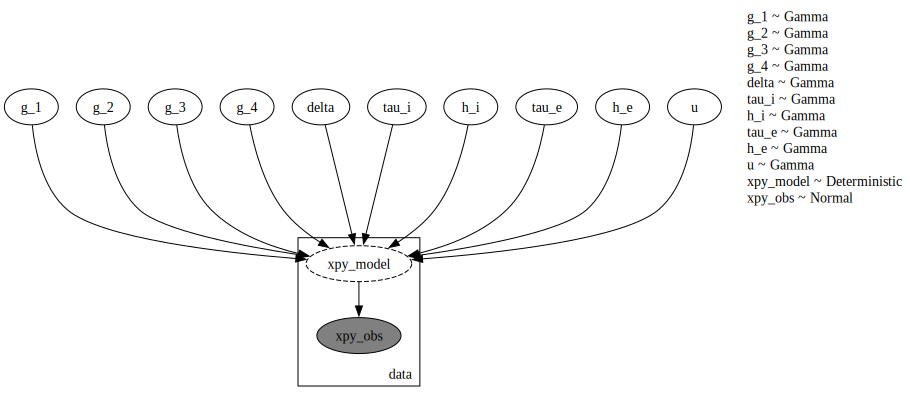

In [37]:
npr.render_model(model, model_args=(data, prior_specs), render_distributions=True, render_params=True)

### Gradient evaluation time

In [38]:
rng_key, rng_key_ = random.split(rng_key)

model_info = npr.infer.util.initialize_model(rng_key_, model, dynamic_args=True, model_args=(data, prior_specs),)

z = model_info.param_info.z

pe_fn = model_info.potential_fn(data, prior_specs)
value_and_grad_jit = jax.jit(jax.value_and_grad(pe_fn))

timings = []
for _ in range(100):
    start_time = time.time()
    value_and_grad_jit(z)[0].block_until_ready()
    timings.append(time.time() - start_time)

In [39]:
print('grad calculation took:', np.mean(timings[1:]))

grad calculation took: 0.0002974813634699041


### Prior predictive check

In [40]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs)

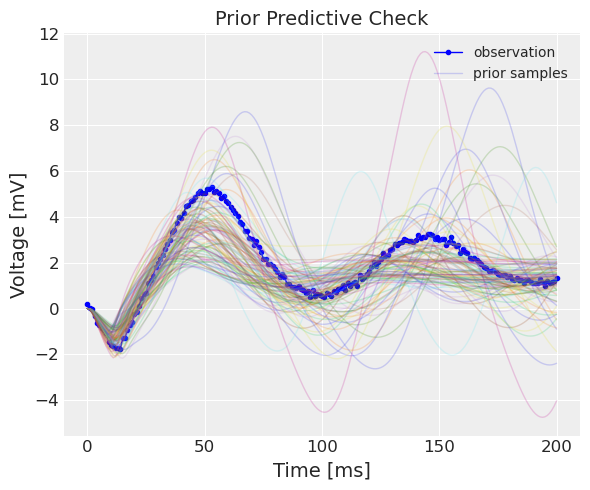

In [41]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title)

## NUTS sampling 

 Due to large dimentionality of problem and the nonlinear relation between parameeters, the multimodality is omnipresence in this case. In the follwing , we first run 4 NUTS chains with default configurations that operates across diverse problems, but not necessarliy leads to convergence. Then we tune the algorithmic parameetrs for better convergence, however, resulting in multimodality. Finnaly, we propose the weighted stacking the chains as a solution to deal with this challnge. 

Axiliary functions

In [42]:
def nuts_diagnostics (mcmc):   
    print('number of LeapFrog in HMC:', mcmc.last_state.num_steps) 

    print('Step size in HMC:', mcmc.last_state.adapt_state.step_size) 

    print("There were {} transitions that exceeded the maximum treedepth.".format(
            (mcmc.get_extra_fields()["num_steps"] + 1 == 2 ** 10).sum()))

    print("There were {} transitions that diverged.".format(
            (mcmc.get_extra_fields()["diverging"] + 1 == 2 ** 10).sum()))

    lp = -mcmc.get_extra_fields()['potential_energy']
    print('Expected log joint density: {:.2f}'.format(np.mean(lp)))

## 1) Fast but Naive NUTS

Lets to run NUTS with smalle values of the max_tree_depth, (which will be saturated for this model) to be naively faster.

In [43]:
# number of warm-up, sampling and chains
n_warmup, n_samples, n_chains =200, 200, 4

In [44]:
# NUTS set up
kernel_naive = NUTS(model, max_tree_depth=8, target_accept_prob=0.8,  dense_mass=False, adapt_step_size=True,  )
mcmc_naive = MCMC(kernel_naive, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, chain_method='parallel')

In [45]:
#RUN NUTS
start_time = time.time()

mcmc_naive.run(rng_key, data, prior_specs, extra_fields=('potential_energy', 'num_steps', 'diverging'))

print(" All Chains using NUTS' Numpyro took (sec):" , (time.time() - start_time))

sample: 100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:19<00:00, 20.93it/s, 255 steps of size 1.43e-03. acc. prob=0.97]


 All Chains using NUTS' Numpyro took (sec): 90.3337197303772


In [46]:
mcmc=mcmc_naive

The values of r_hat>>1 show no convergence. This lack of convergence leads to a very low effective sample size.

In [47]:
mcmc.print_summary(exclude_deterministic=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta     11.59      1.90     12.08     10.94     13.25      9.70      1.57
       g_1      0.60      0.23      0.52      0.34      1.03      2.21      3.70
       g_2      0.67      0.17      0.67      0.50      0.91     21.61      1.16
       g_3      0.17      0.09      0.15      0.10      0.23     20.29      1.15
       g_4      0.23      0.04      0.22      0.16      0.28     17.15      1.21
       h_e      2.00      0.68      1.84      1.39      2.50     16.96      1.31
       h_i     17.40      4.43     17.81     10.07     23.50     13.45      1.35
     tau_e      6.35      2.07      5.80      5.23      6.34      9.70      1.52
     tau_i      7.68      0.34      7.73      7.52      7.97     36.44      1.10
         u      2.36      0.78      2.47      0.94      3.65      3.14      2.40

Number of divergences: 0


###  Outputs of Naive NUTS

In [48]:
nuts_diagnostics (mcmc)

number of LeapFrog in HMC: [255 255 255 255]
Step size in HMC: [0.00240946 0.02284977 0.00991618 0.00142562]
There were 0 transitions that exceeded the maximum treedepth.
There were 0 transitions that diverged.
Expected log joint density: 111.76


In [49]:
lp = -mcmc.get_extra_fields()['potential_energy']

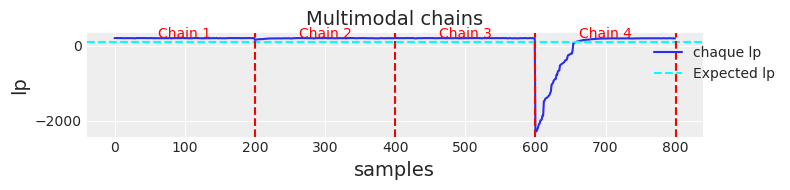

In [50]:
title='Multimodal chains'
plot_lp_chains(lp, n_chains, title)

In [51]:
az_obj = az.from_numpyro(mcmc)

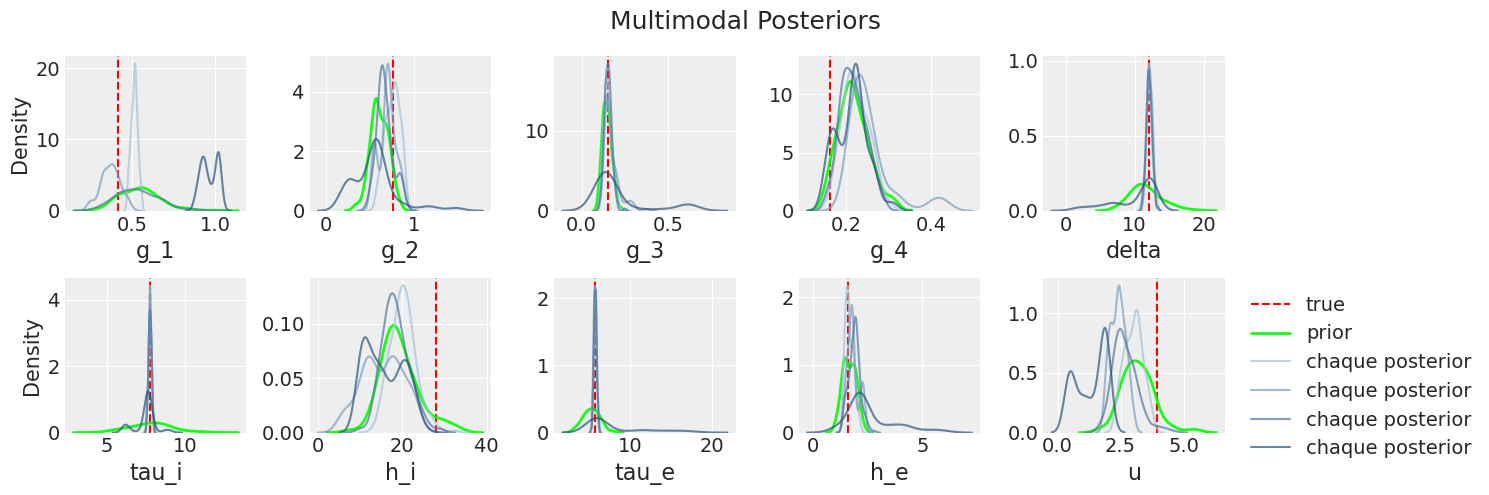

In [52]:
title="Multimodal Posteriors"
plot_posterior_multimodal(my_var_names, theta_true, prior_predictions, az_obj.posterior, title)

### Pooled posterior of Naive NUTS

In [53]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

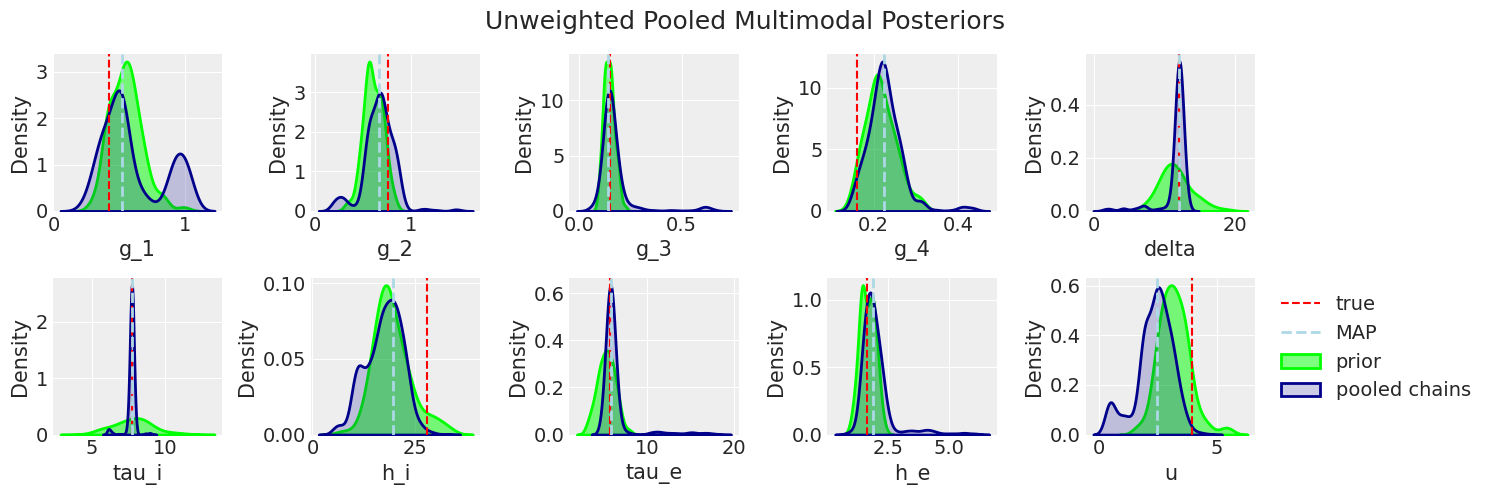

In [54]:
title="Unweighted Pooled Multimodal Posteriors"
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_pooled, title)

### Fit and Posterior predictive check using Naive NUTS

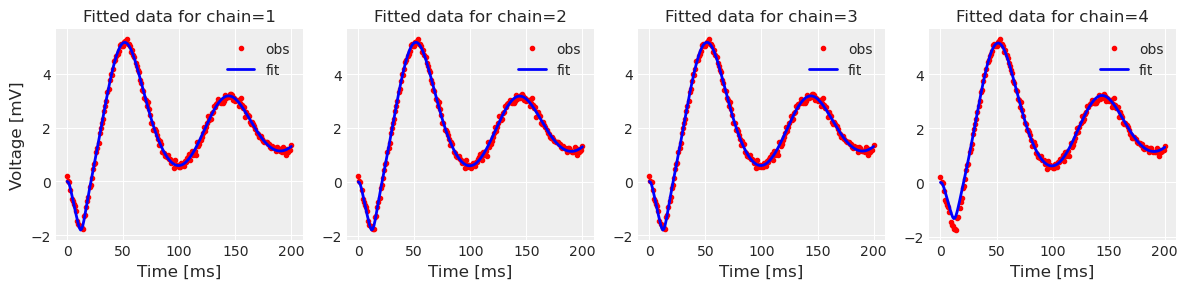

In [55]:
plot_fitted(data, az_obj.posterior)

Note that from the fitted observation, we may not necessarily delineate the chains that did not converged. It also may fail to a false estimation if we pool all chains.

In [56]:
pooled_posterior_samples = mcmc.get_samples()
pooled_posterior_predictive = Predictive(model=model, posterior_samples=pooled_posterior_samples)
rng_key, rng_subkey = random.split(key=rng_key)
pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, data, prior_specs)
ppc_=pooled_posterior_predictive_samples['xpy_model']

xpy_per05_pooled=np.quantile(ppc_, 0.05, axis=0)
xpy_per95_pooled=np.quantile(ppc_, 0.95, axis=0)

In [57]:
pooled_idata = az.from_numpyro(posterior=mcmc, posterior_predictive=pooled_posterior_predictive_samples)
x_fit_ppc = pooled_idata.posterior_predictive['xpy_model']

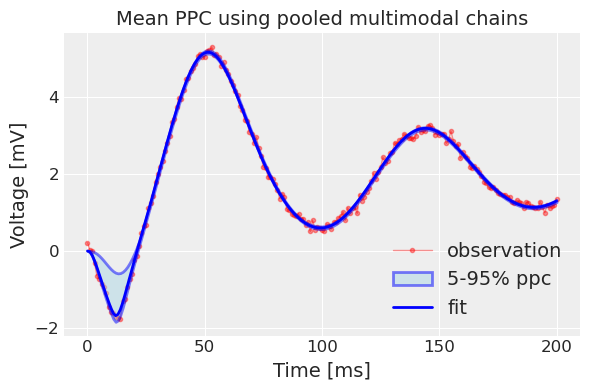

In [58]:
title='Mean PPC using pooled multimodal chains'
plot_posteriorcheck(data, xpy_per05_pooled, xpy_per95_pooled, title)
plt.plot(ts_obs, x_fit_ppc.mean(axis=(0, 1)), lw=2, color='b', label='fit'); plt.legend();

### Out-of-sample prediction using pooled chains of Naive NUTS

In [59]:
joint_sample_, ppc_, xpy_per5_, xpy_per95_, x_map_=out_of_samples_ppc_vales(data, ERP_JAXOdeintSimuator, chains_pooled, n_)

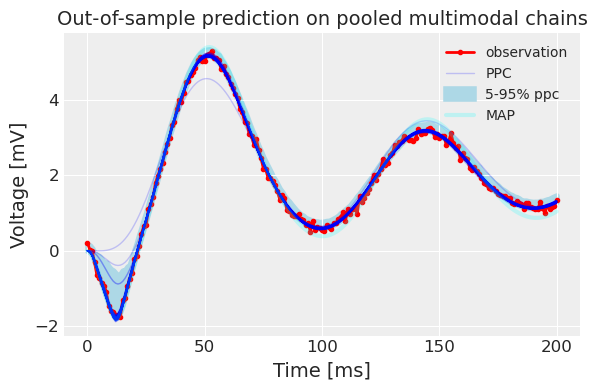

In [60]:
title='Out-of-sample prediction on pooled multimodal chains'
plot_out_of_sample_ppc_values(data, ERP_JAXOdeintSimuator,joint_sample_, xpy_per5_, xpy_per95_, x_map_, n_, title)

NOTES: By this setup, the chains may converge or not. We can see that there are samples that hitted the max tree-depth, which may lead to mature convergence as for those the chains trce back to the initial condition. The convergence can be checked by monitoring the \hat R, close to 1 as a rule of thumb, also the Rank Plot, and Effective Sample Size (EES) which we will see in the following.

## 2) Weighted stacking as a remedy for multimodality

Now we took the chains ran with default values that very likely the multimodality happens!

In [61]:
mcmc=mcmc_naive
az_obj = az.from_numpyro(mcmc)
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

### Weighting the chains based on elpd (expected log predictive density) 

Create a dictionnary of the different "models" we are going to compare - here each model is one of the chain

In [62]:
name = []
post = []
for i in range(n_chains) :
    post.append(az_obj.sel(chain=[i]))
    name.append(str(i))
    
chains_dict = dict(zip(name, post))

In [63]:
chains = az_obj.posterior[my_var_names].to_array() #extract posterior inference just for parameters

Getting weighted samples with arviz

In [64]:
comp_stack = az.compare(chains_dict, method='stacking')
comp_stack

rank     elpd_loo        p_loo    elpd_diff        weight          se  \
2     0   194.887491     3.990946     0.000000  1.000000e+00    8.172734   
1     1   194.669515     4.480227     0.217975  7.327472e-15    8.214655   
0     2   194.239135     4.400478     0.648356  0.000000e+00    8.179051   
3     3 -1566.273196  1750.138471  1761.160687  0.000000e+00  354.383989   

          dse  warning scale  
2    0.000000     True   log  
1    0.368458     True   log  
0    0.207563     True   log  
3  354.190364     True   log

In [65]:
stack_weights = np.array(comp_stack.sort_index()['weight'])
stack_weights

array([0.00000000e+00, 7.32747196e-15, 1.00000000e+00, 0.00000000e+00])

If not already have a posterior_predictive and observed_data groups, add them with following:

In [66]:
#copy posterior to posterior predictive and add observed_data to be able to use function weight_prediction of arviz
list_chains = list(chains_dict.values())
for ichain in range(len(list_chains)) :
    list_chains[ichain].add_groups(posterior_predictive=list_chains[ichain].posterior.copy())

In [67]:
w_post = az.weight_predictions(list_chains, stack_weights)
chains_stacked=w_post.posterior_predictive[my_var_names].to_array().values

In [68]:
params_map_stacked=calcula_map(chains_stacked)

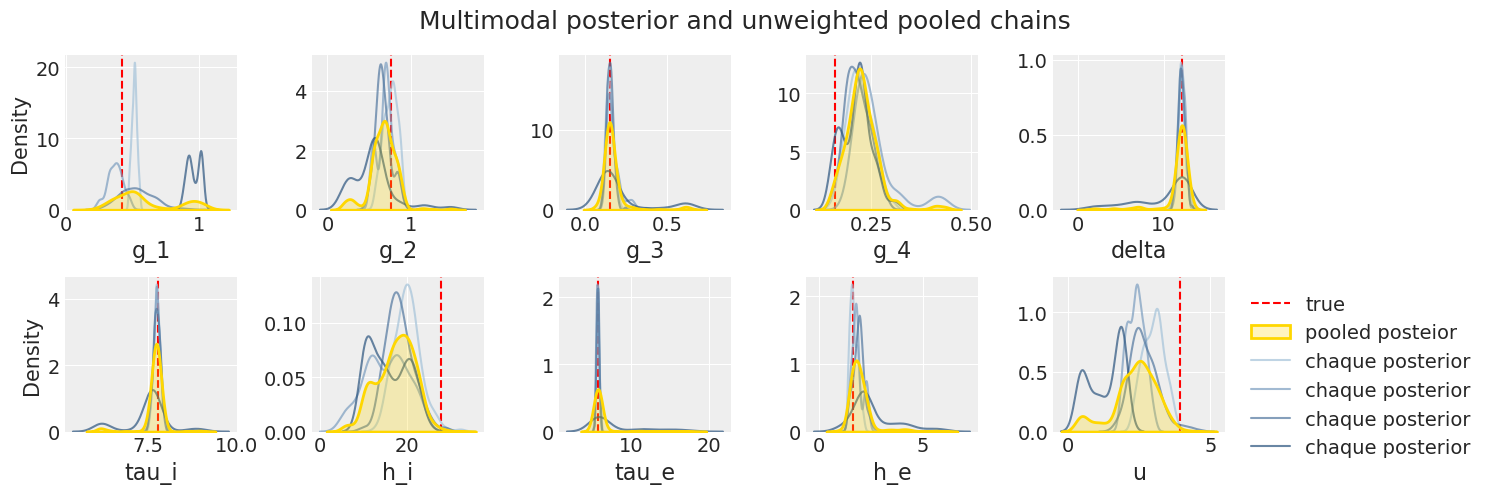

In [69]:
title='Multimodal posterior and unweighted pooled chains'
plot_posterior_pooled_multimodal(my_var_names, theta_true,  prior_predictions, az_obj.posterior, chains_pooled, title)

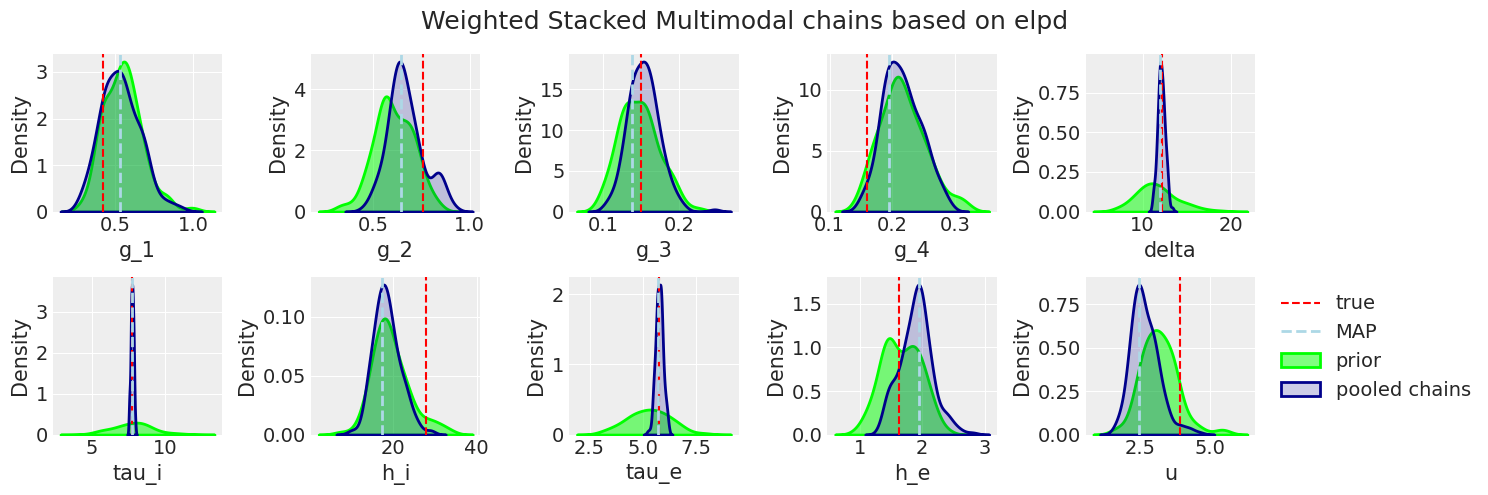

In [70]:
title="Weighted Stacked Multimodal chains based on elpd"
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_stacked, title)

### Posterior Predictive Check using stacked chains

In [71]:
joint_sample_, ppc_, xpy_per5_, xpy_per95_, x_map_=out_of_samples_ppc_vales(data, ERP_JAXOdeintSimuator, chains_stacked, n_)

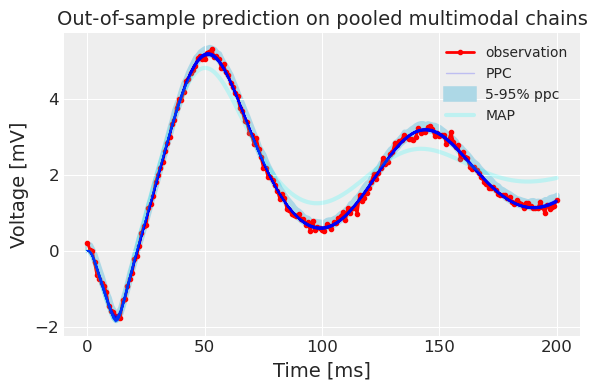

In [72]:
title='Out-of-sample prediction on pooled multimodal chains'
plot_out_of_sample_ppc_values(data, ERP_JAXOdeintSimuator,joint_sample_, xpy_per5_, xpy_per95_, x_map_, n_, title)

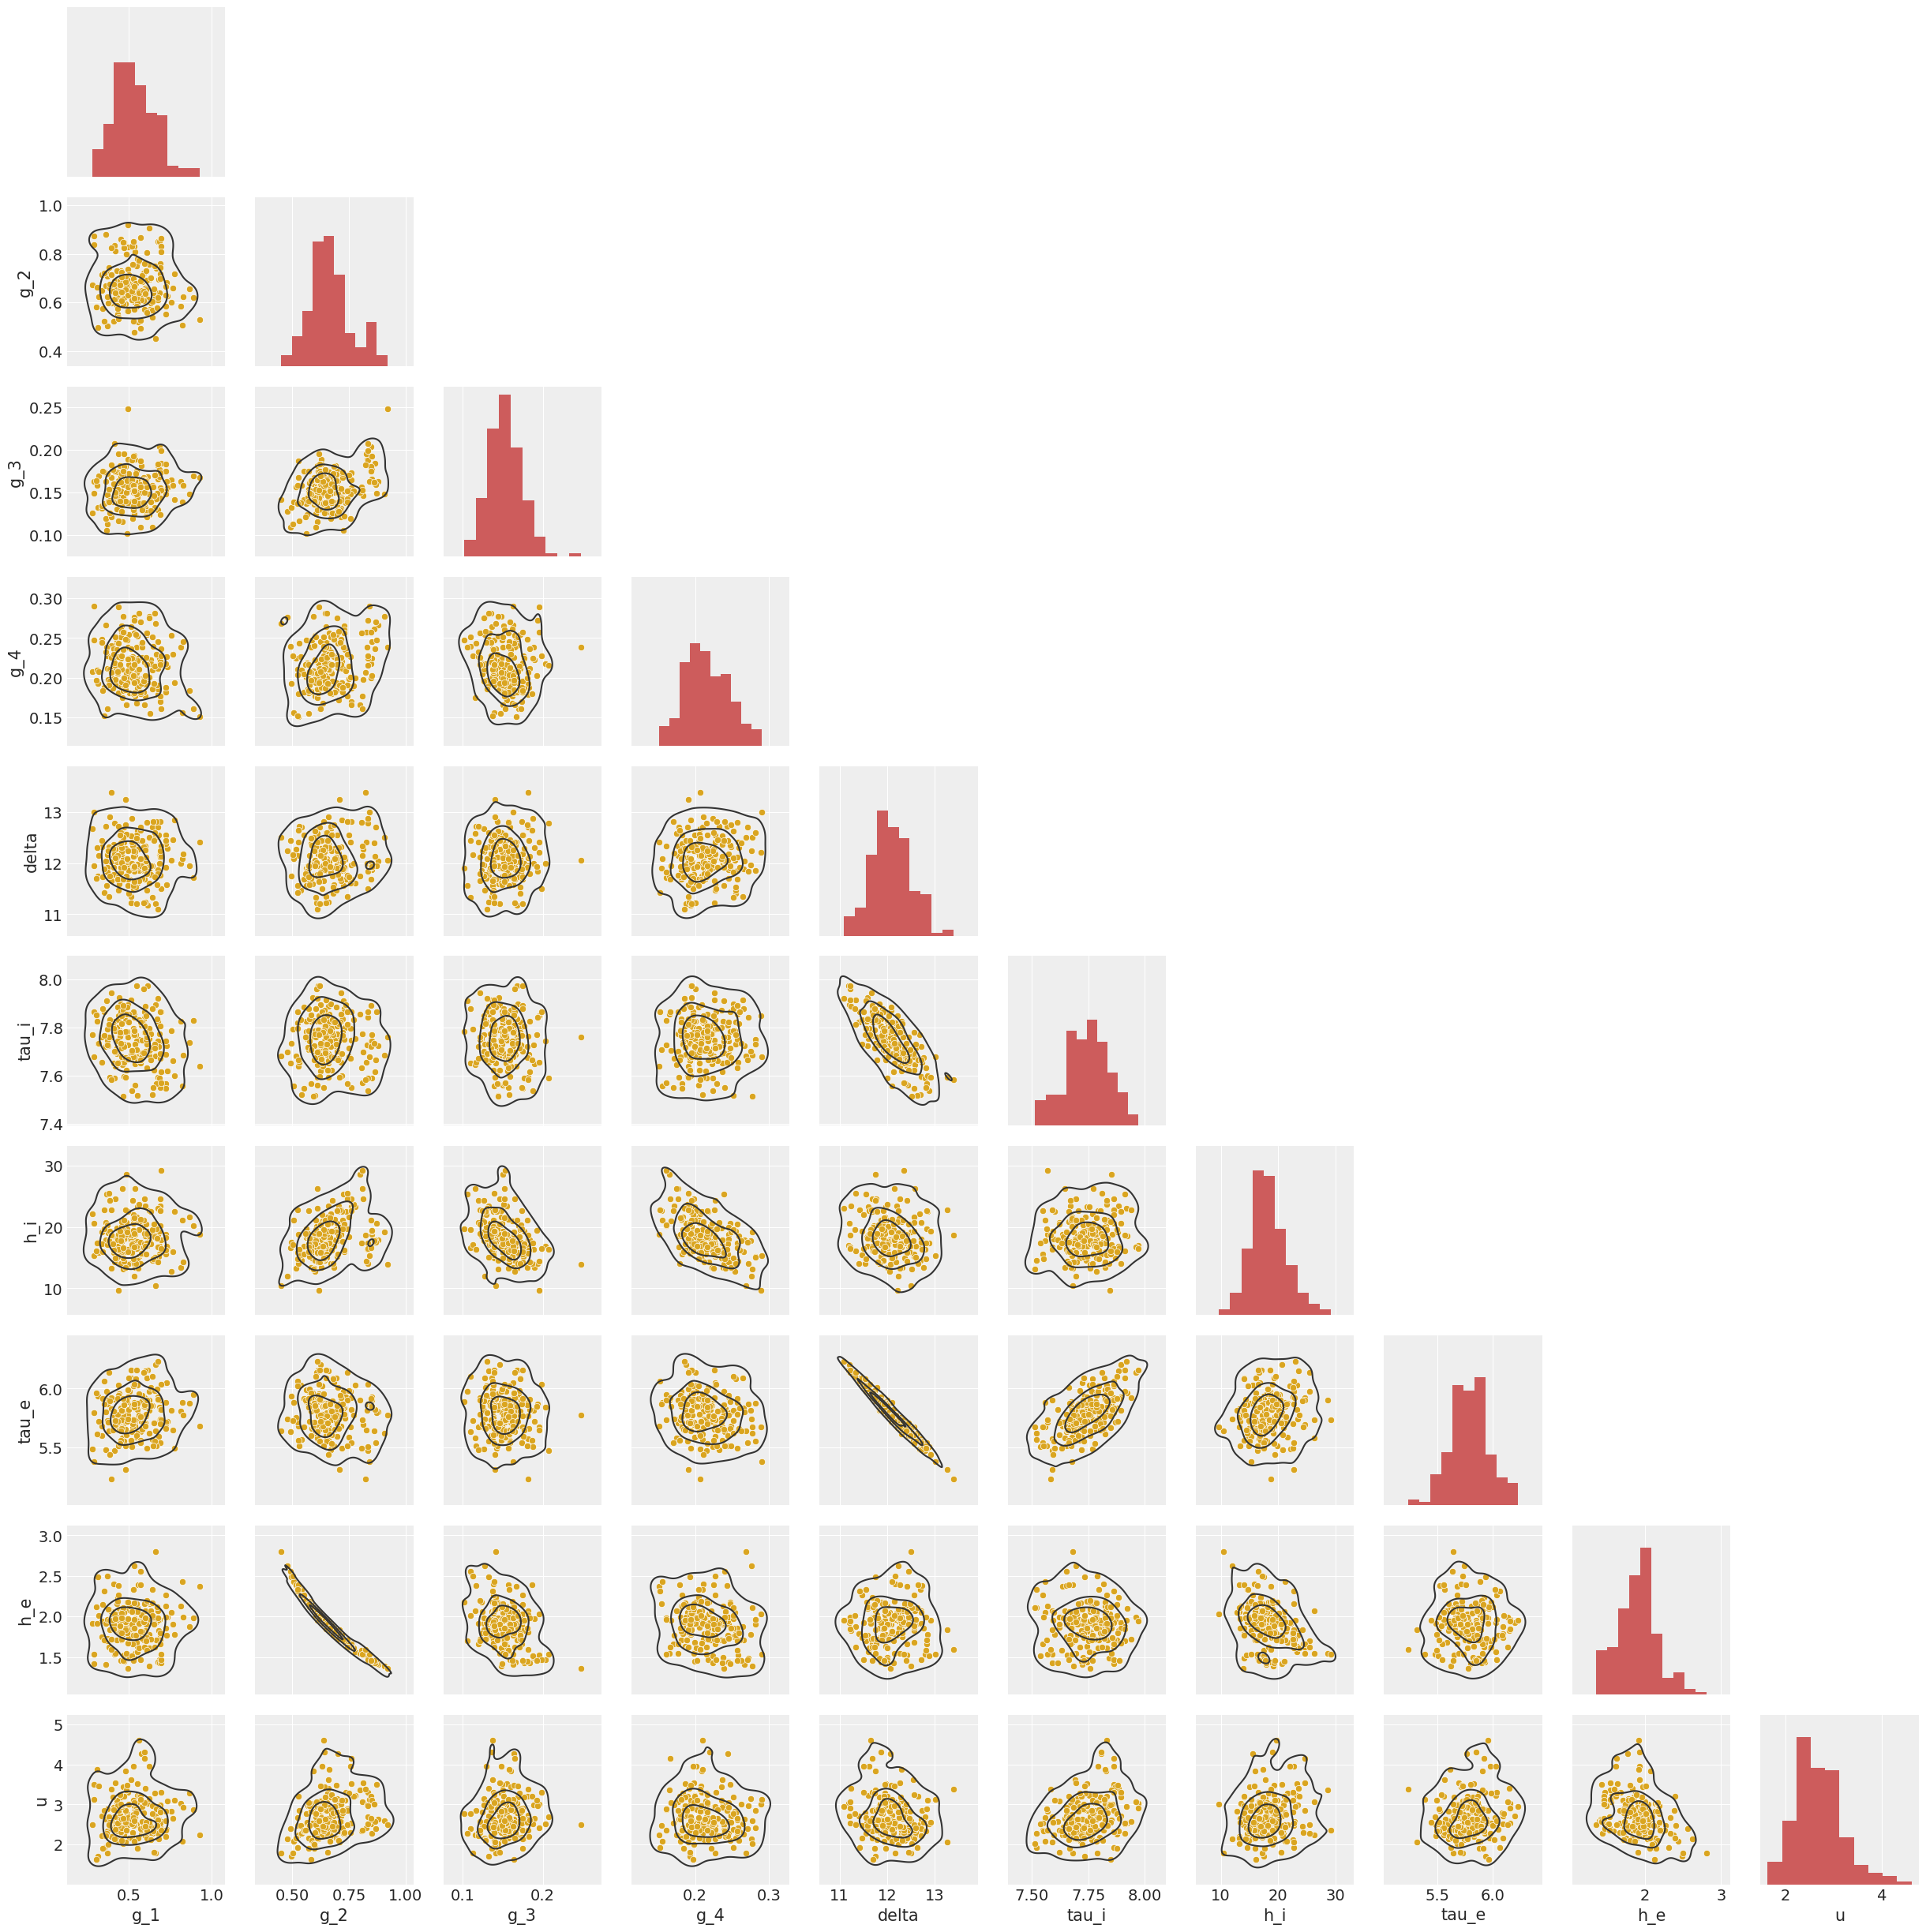

In [73]:
g = sns.PairGrid(w_post.posterior_predictive[my_var_names].to_pandas()[my_var_names], corner=True)
g.map_lower(sns.scatterplot, color='goldenrod');
g.map_diag(plt.hist, color='indianred');
g.map_lower(sns.kdeplot, levels=4, color=".2");

## 3)  but something as it should be for the sake of convergence

Now we run the chains at the tail of prior to get convergence for all chains. Here we uniformly sample at the tail of prior, hence it may be locatd at left or right side of  the prior distbutions.

In [74]:
gamma_prior_q, low_prob_sample_vals, q_ =low_prob_sample(my_var_names, prior_predictions, )
init_to_low_prob = init_to_value(values=dict(zip(my_var_names, low_prob_sample_vals)))

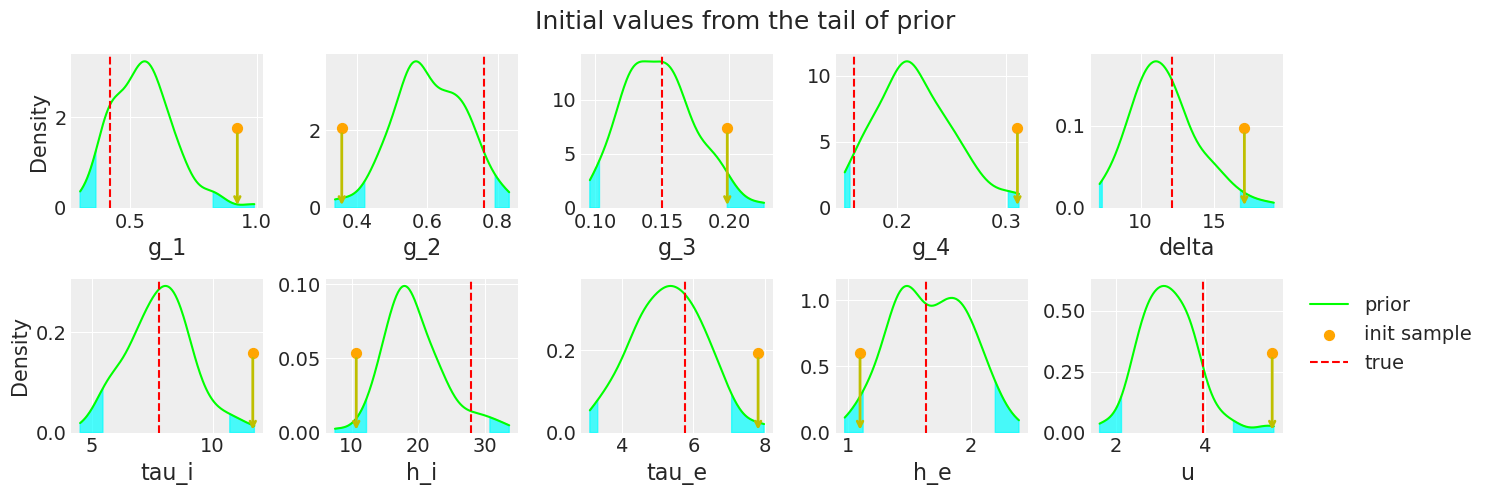

In [75]:
plot_prior_tail(my_var_names, theta_true, gamma_prior_q, low_prob_sample_vals, q_)

In [76]:
# NUTS set up
kernel_tuned = NUTS(model, max_tree_depth=12,  dense_mass=False, adapt_step_size=True, init_strategy=init_to_low_prob)
mcmc_tuned = MCMC(kernel_tuned, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, chain_method='parallel')

In [77]:
#RUN NUTS
start_time = time.time()

mcmc_tuned.run(rng_key, data, prior_specs, extra_fields=('potential_energy', 'num_steps', 'diverging'))

print(" All Chains using NUTS' Numpyro took (sec):" , (time.time() - start_time))

sample: 100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [01:01<00:00,  6.52it/s, 511 steps of size 1.05e-02. acc. prob=0.93]


 All Chains using NUTS' Numpyro took (sec): 218.62317895889282


In [78]:
mcmc=mcmc_tuned

The values of r_hat ~1 show the convergence. This convergence leads to a large effective sample size.

In [79]:
mcmc.print_summary(exclude_deterministic=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta     12.05      0.39     12.05     11.41     12.70    497.40      1.00
       g_1      0.55      0.13      0.53      0.36      0.78    741.51      1.00
       g_2      0.68      0.07      0.68      0.56      0.80    621.55      1.00
       g_3      0.15      0.02      0.15      0.12      0.19    517.24      1.00
       g_4      0.22      0.03      0.21      0.15      0.26    635.93      1.00
       h_e      1.84      0.20      1.83      1.51      2.16    636.13      1.01
       h_i     19.50      3.60     19.19     13.83     24.80    513.69      1.01
     tau_e      5.80      0.17      5.80      5.52      6.06    501.37      1.00
     tau_i      7.75      0.09      7.75      7.61      7.90    669.69      1.00
         u      2.75      0.47      2.69      2.01      3.51    717.06      1.00

Number of divergences: 0


### Save your fitted mcmc object 

In [80]:
with open(output_dir + "mcmc_GammaPrior_max_treedepth=12_Tailedinitialized.pickle", "wb") as output_file:
    pickle.dump(mcmc, output_file)

So you can load it later

In [81]:
with open(output_dir + "mcmc_GammaPrior_max_treedepth=12_Tailedinitialized.pickle", "rb") as input_file:
    mcmc = pickle.load(input_file)

### Outputs of convergenced NUTS

In [82]:
nuts_diagnostics (mcmc)

number of LeapFrog in HMC: [255 511 383 511]
Step size in HMC: [0.01446608 0.01036587 0.009364   0.01049965]
There were 5 transitions that exceeded the maximum treedepth.
There were 0 transitions that diverged.
Expected log joint density: 201.16


In [83]:
lp = -mcmc.get_extra_fields()['potential_energy']

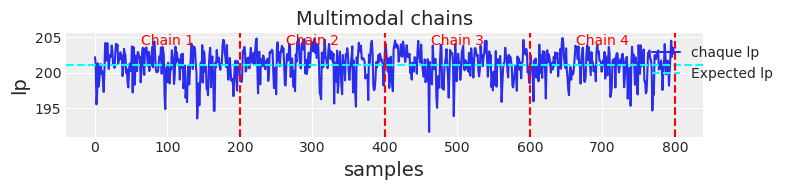

In [84]:
title='Multimodal chains'
plot_lp_chains(lp, n_chains, title)

NOTES: By this setup, the chains converge. We can see that there are samples that hitted the max tree-depth is much less compated to default values, which lead to better convergence. In the case of apearing the multimadility, then the weighted stacking chains can solve the issues. 

### Posterior of convergenced NUTS

In [85]:
# Get posterior samples
posterior_samples = mcmc.get_samples(group_by_chain=True)
pooled_posterior_samples = mcmc.get_samples()

vizualize with arviz

In [86]:
az_obj = az.from_numpyro(mcmc)

In [87]:
az.summary(az_obj, my_var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
g_1     0.548  0.127   0.324    0.792      0.005    0.003     745.0     550.0   
g_2     0.683  0.074   0.543    0.817      0.003    0.002     635.0     592.0   
g_3     0.149  0.023   0.110    0.195      0.001    0.001     541.0     483.0   
g_4     0.215  0.033   0.153    0.277      0.001    0.001     665.0     614.0   
delta  12.051  0.392  11.314   12.771      0.017    0.012     513.0     424.0   
tau_i   7.754  0.090   7.575    7.916      0.003    0.002     690.0     635.0   
h_i    19.500  3.603  13.397   25.995      0.155    0.109     550.0     580.0   
tau_e   5.802  0.171   5.519    6.151      0.008    0.005     524.0     505.0   
h_e     1.839  0.200   1.517    2.269      0.008    0.006     655.0     592.0   
u       2.750  0.467   1.935    3.620      0.017    0.012     761.0     635.0   

       r_hat  
g_1     1.00  
g_2     1.00  
g_3     1.00  
g_4     1.01  
delta   1.00  
tau_i   1.00  
h_i     1.01  
tau_e   1.00  
h_e     1.00  
u       1.01

showing the posterior samples of all chains

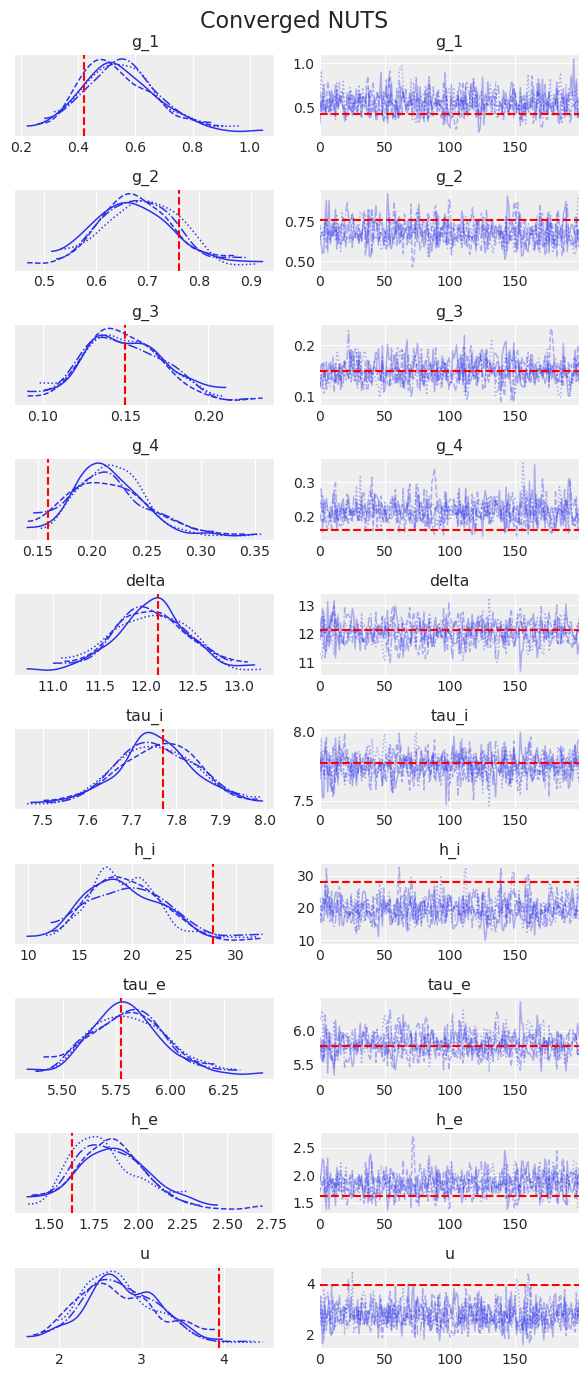

In [88]:
axes = az.plot_trace(
    az_obj,
    var_names=my_var_names,
    compact=True,
    kind="trace",
    backend_kwargs={"figsize": (6, 14), "layout": "constrained"},)

for ax, true_val in zip(axes[:, 0], theta_true):
    ax.axvline(x=true_val, color='red', linestyle='--')
for ax, true_val in zip(axes[:, 1], theta_true):
    ax.axhline(y=true_val, color='red', linestyle='--')
    
plt.gcf().suptitle("Converged NUTS", fontsize=16)
plt.tight_layout();

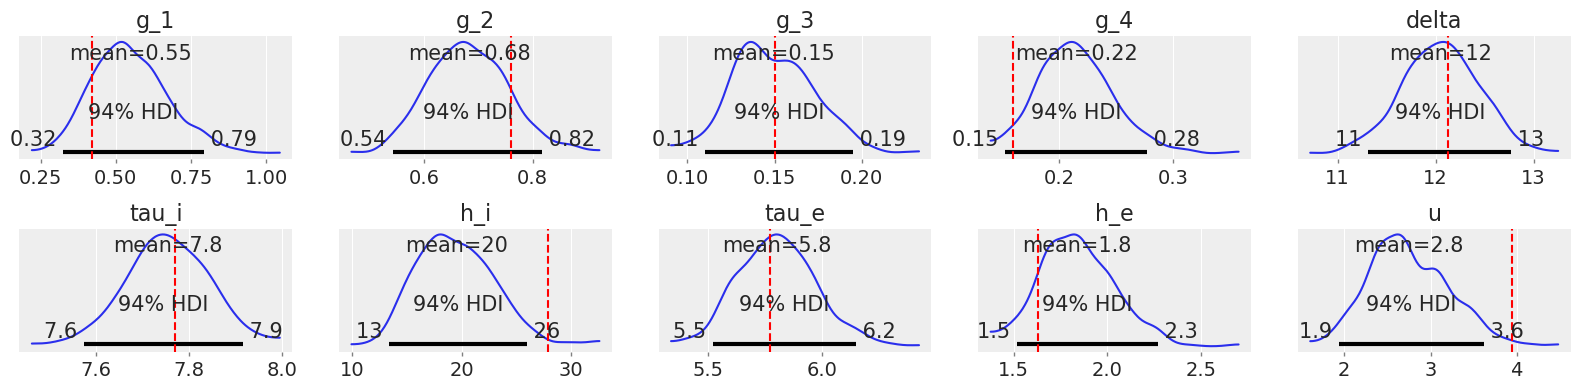

In [89]:
axes = az.plot_posterior(az_obj,
    var_names=my_var_names,
    backend_kwargs={"figsize": (16, 4), "layout": "constrained"},  grid=(2, 5))
    
for ax, true_value in zip(axes.ravel(), theta_true):
    ax.axvline(true_value, color='r', linestyle='--')

plt.tight_layout();

In [90]:
rmse_prms = np.sqrt(np.mean((theta_true - az_obj.posterior[my_var_names].mean().to_array().values)**2))
rmse_prms

2.674800130239322

### More dignostics on convergenced NUTS

shwoing the rank plot as it should be unifrom by convergence:

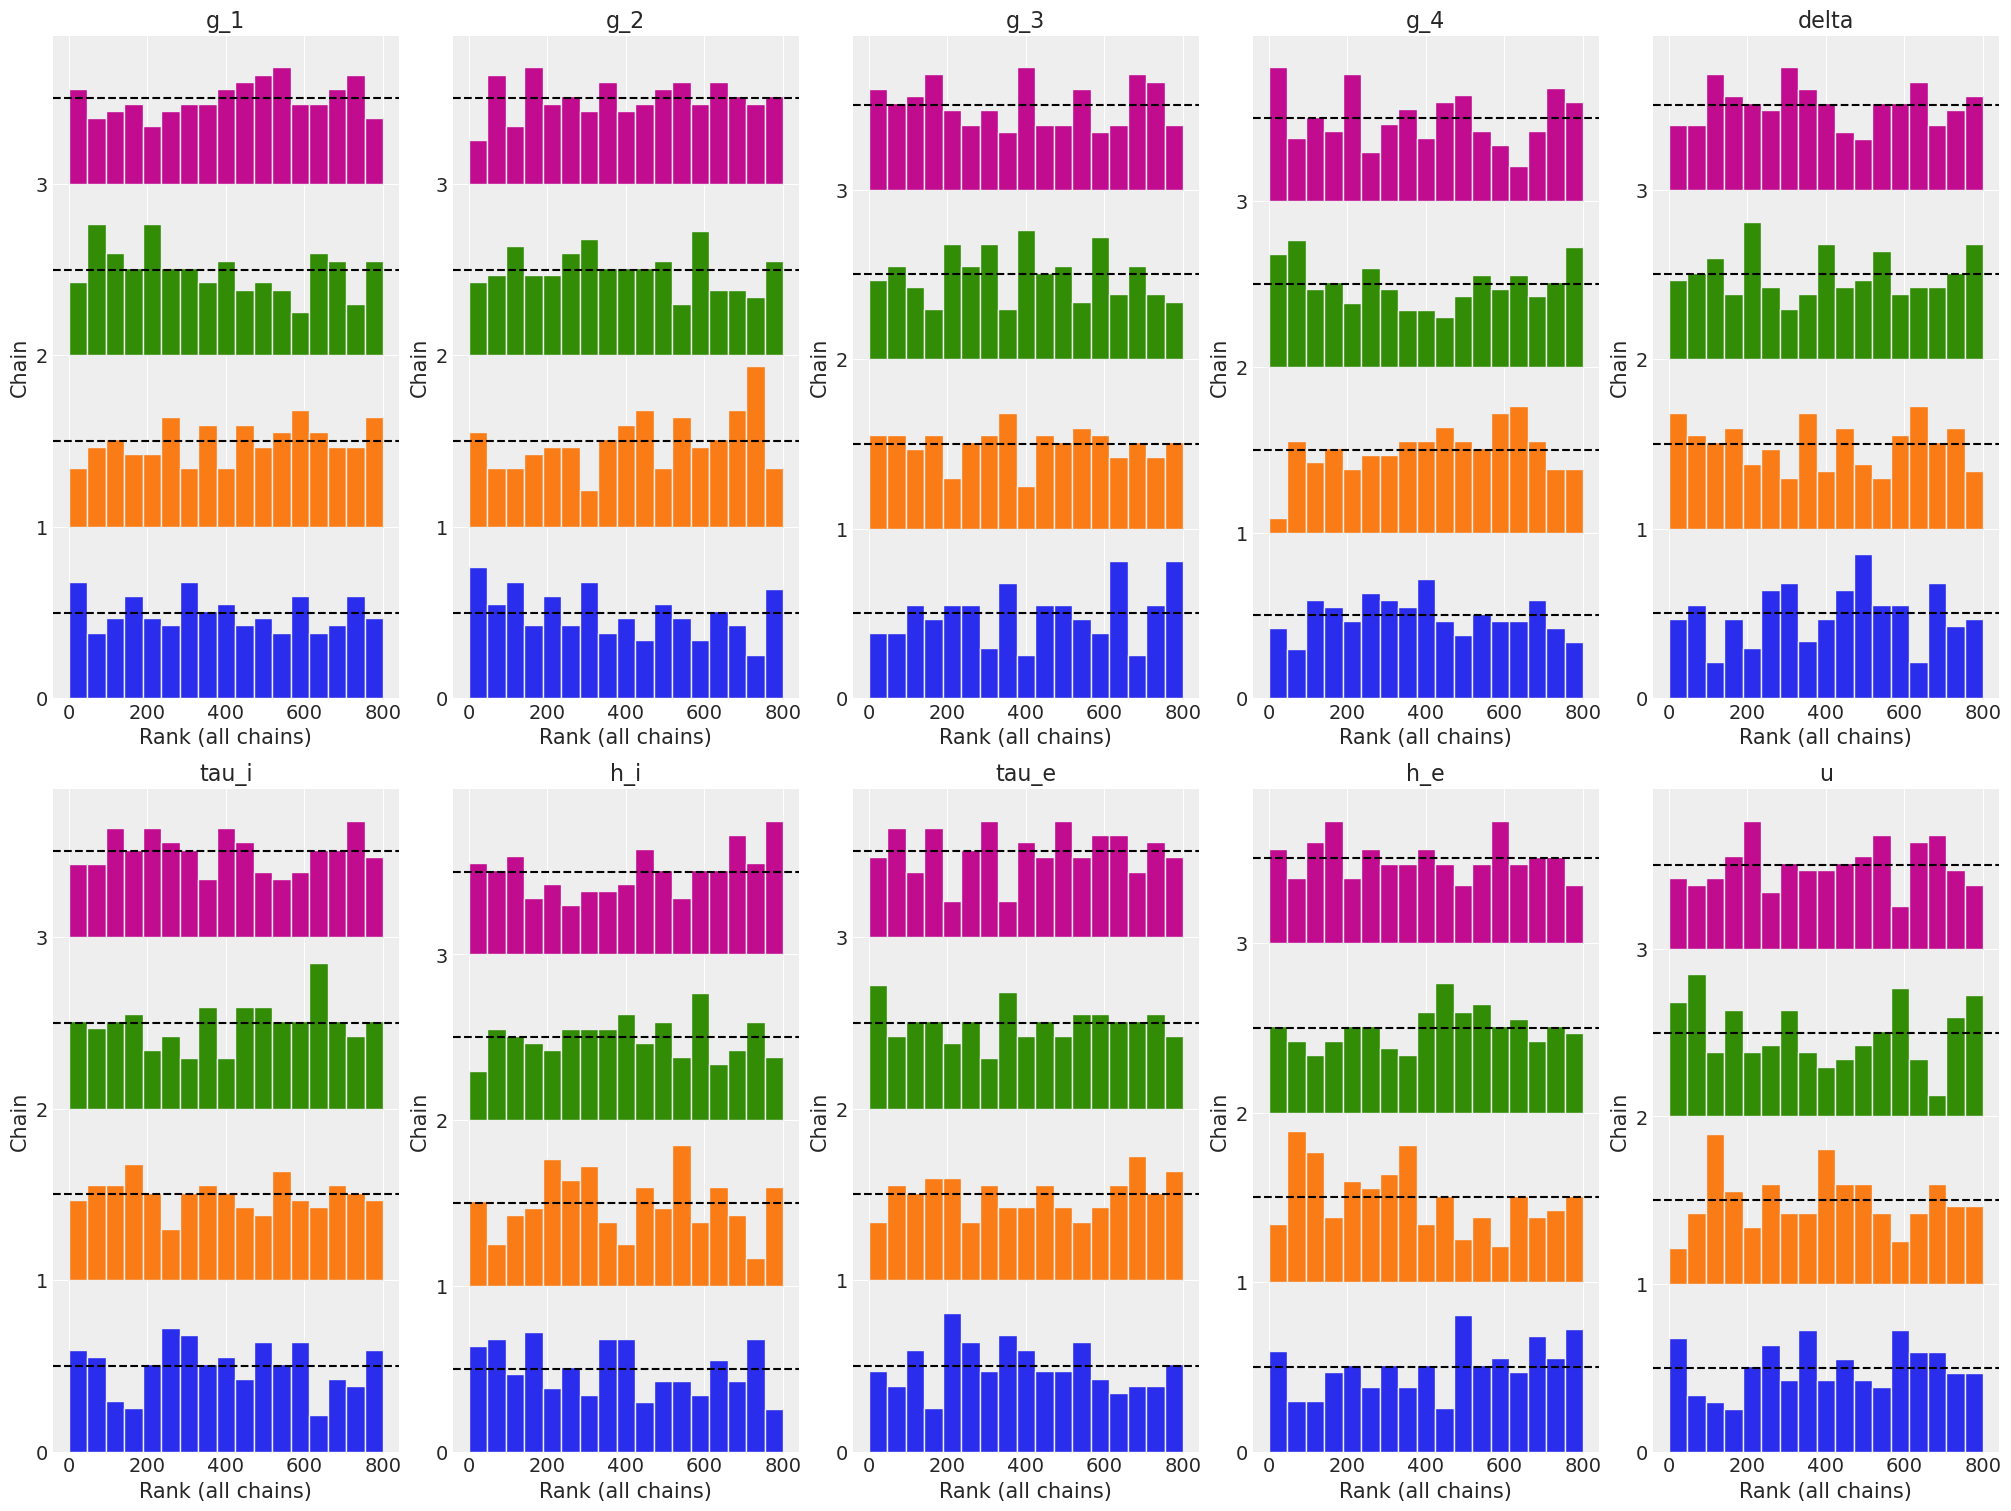

In [91]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20, 15))
for iprm, prm in enumerate(my_var_names) :
    a = ax[iprm//5, iprm%5]
    az.plot_rank(az_obj, var_names=my_var_names[iprm], ax=a)

showing the effective number of samples, which should uniformly increase by convergence

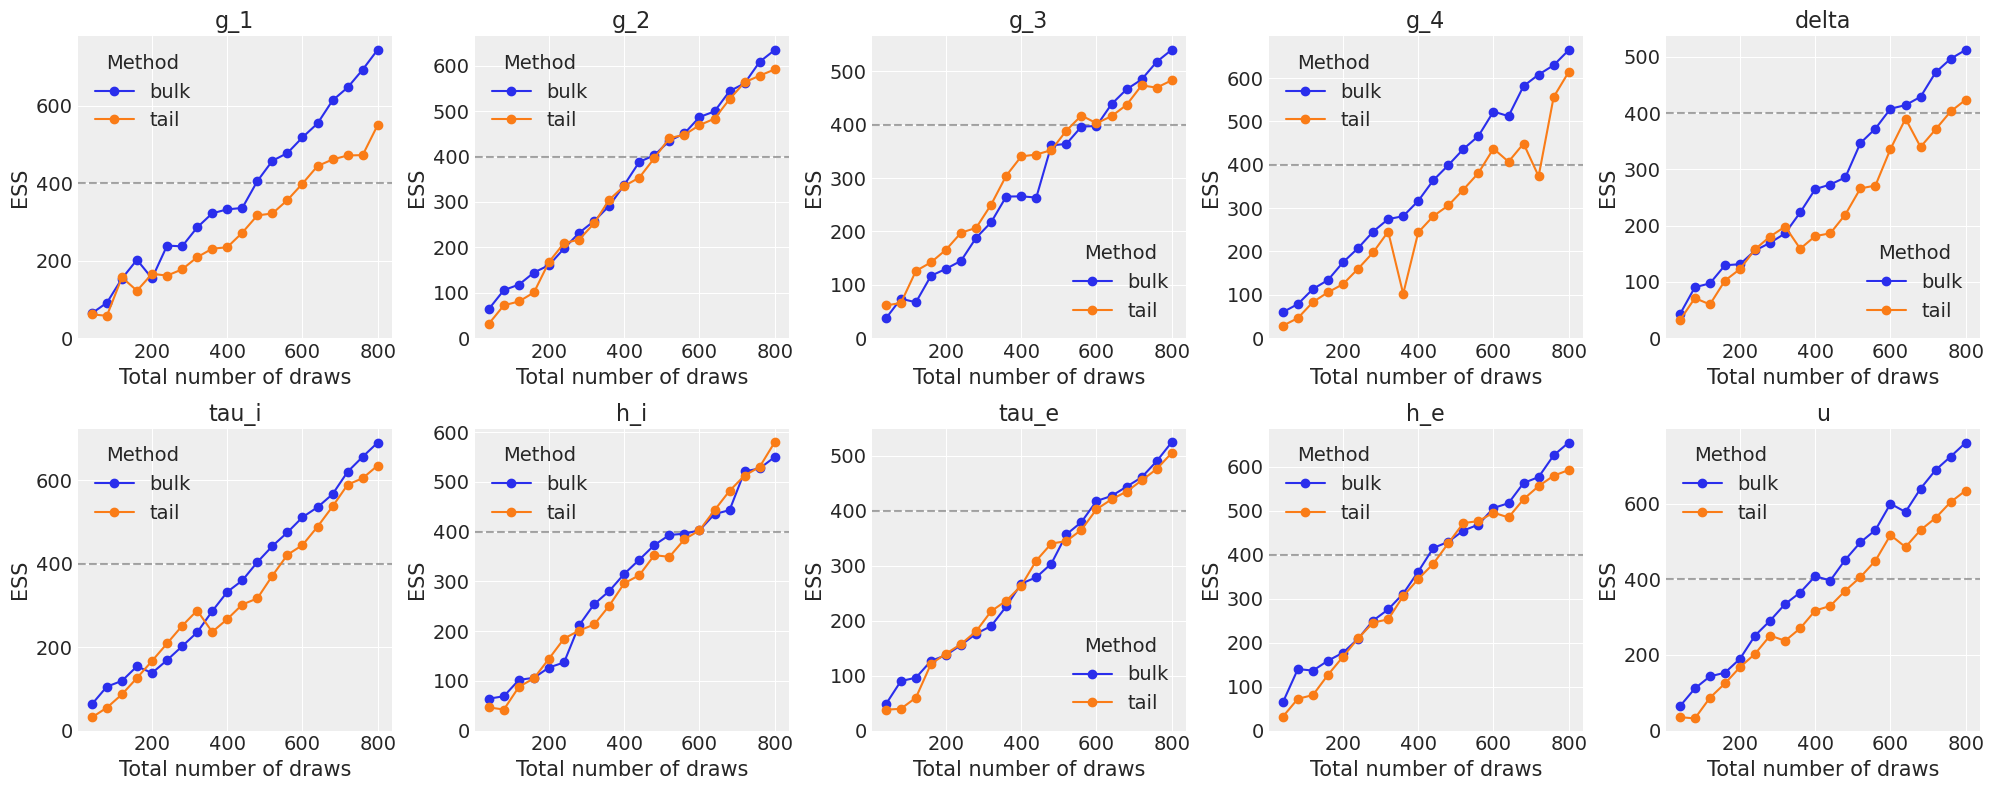

In [92]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))
for iprm, prm in enumerate(my_var_names) :
    a = ax[iprm//5, iprm%5]
    az.plot_ess(az_obj, var_names=my_var_names[iprm], kind='evolution', ax=a)
fig.tight_layout()

### Pooled posterior of convergenced NUTS

In [93]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

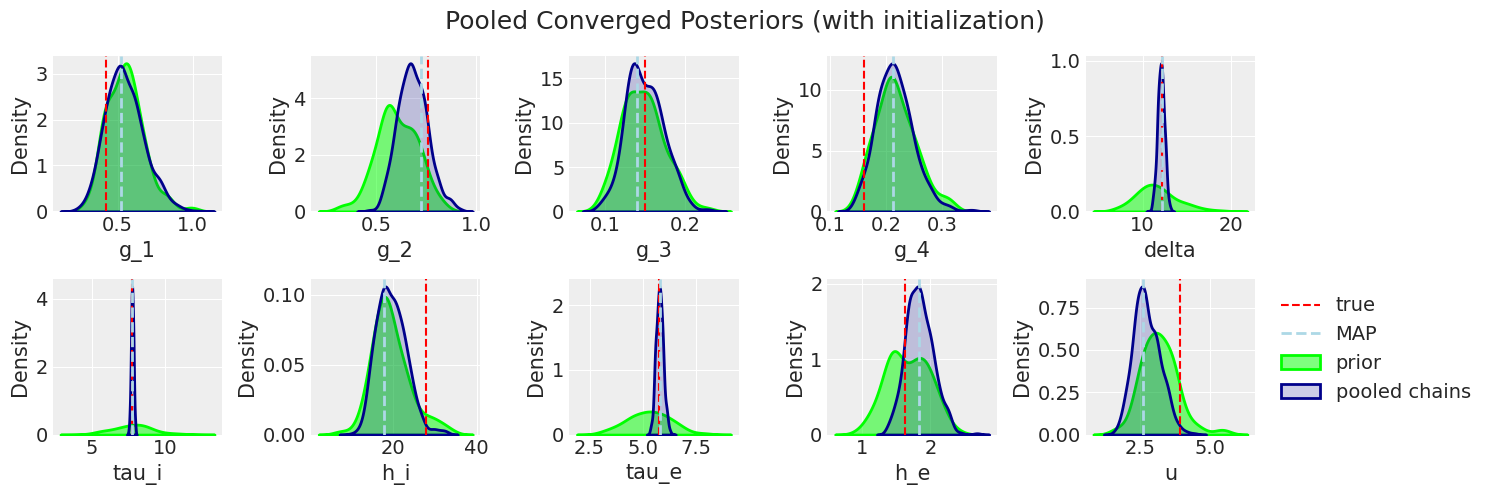

In [94]:
title='Pooled Converged Posteriors (with initialization)'
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_pooled, title)

### Relation between params using convergenced NUTS

In [95]:
corr_vals=np.corrcoef(chains_pooled)

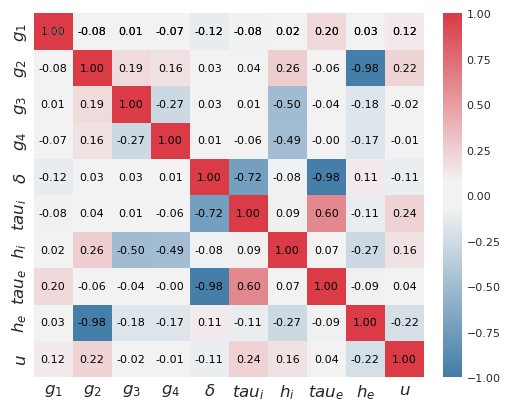

In [96]:
plot_corr(corr_vals, params_labels)

Joint posterior to see the relation between parameters

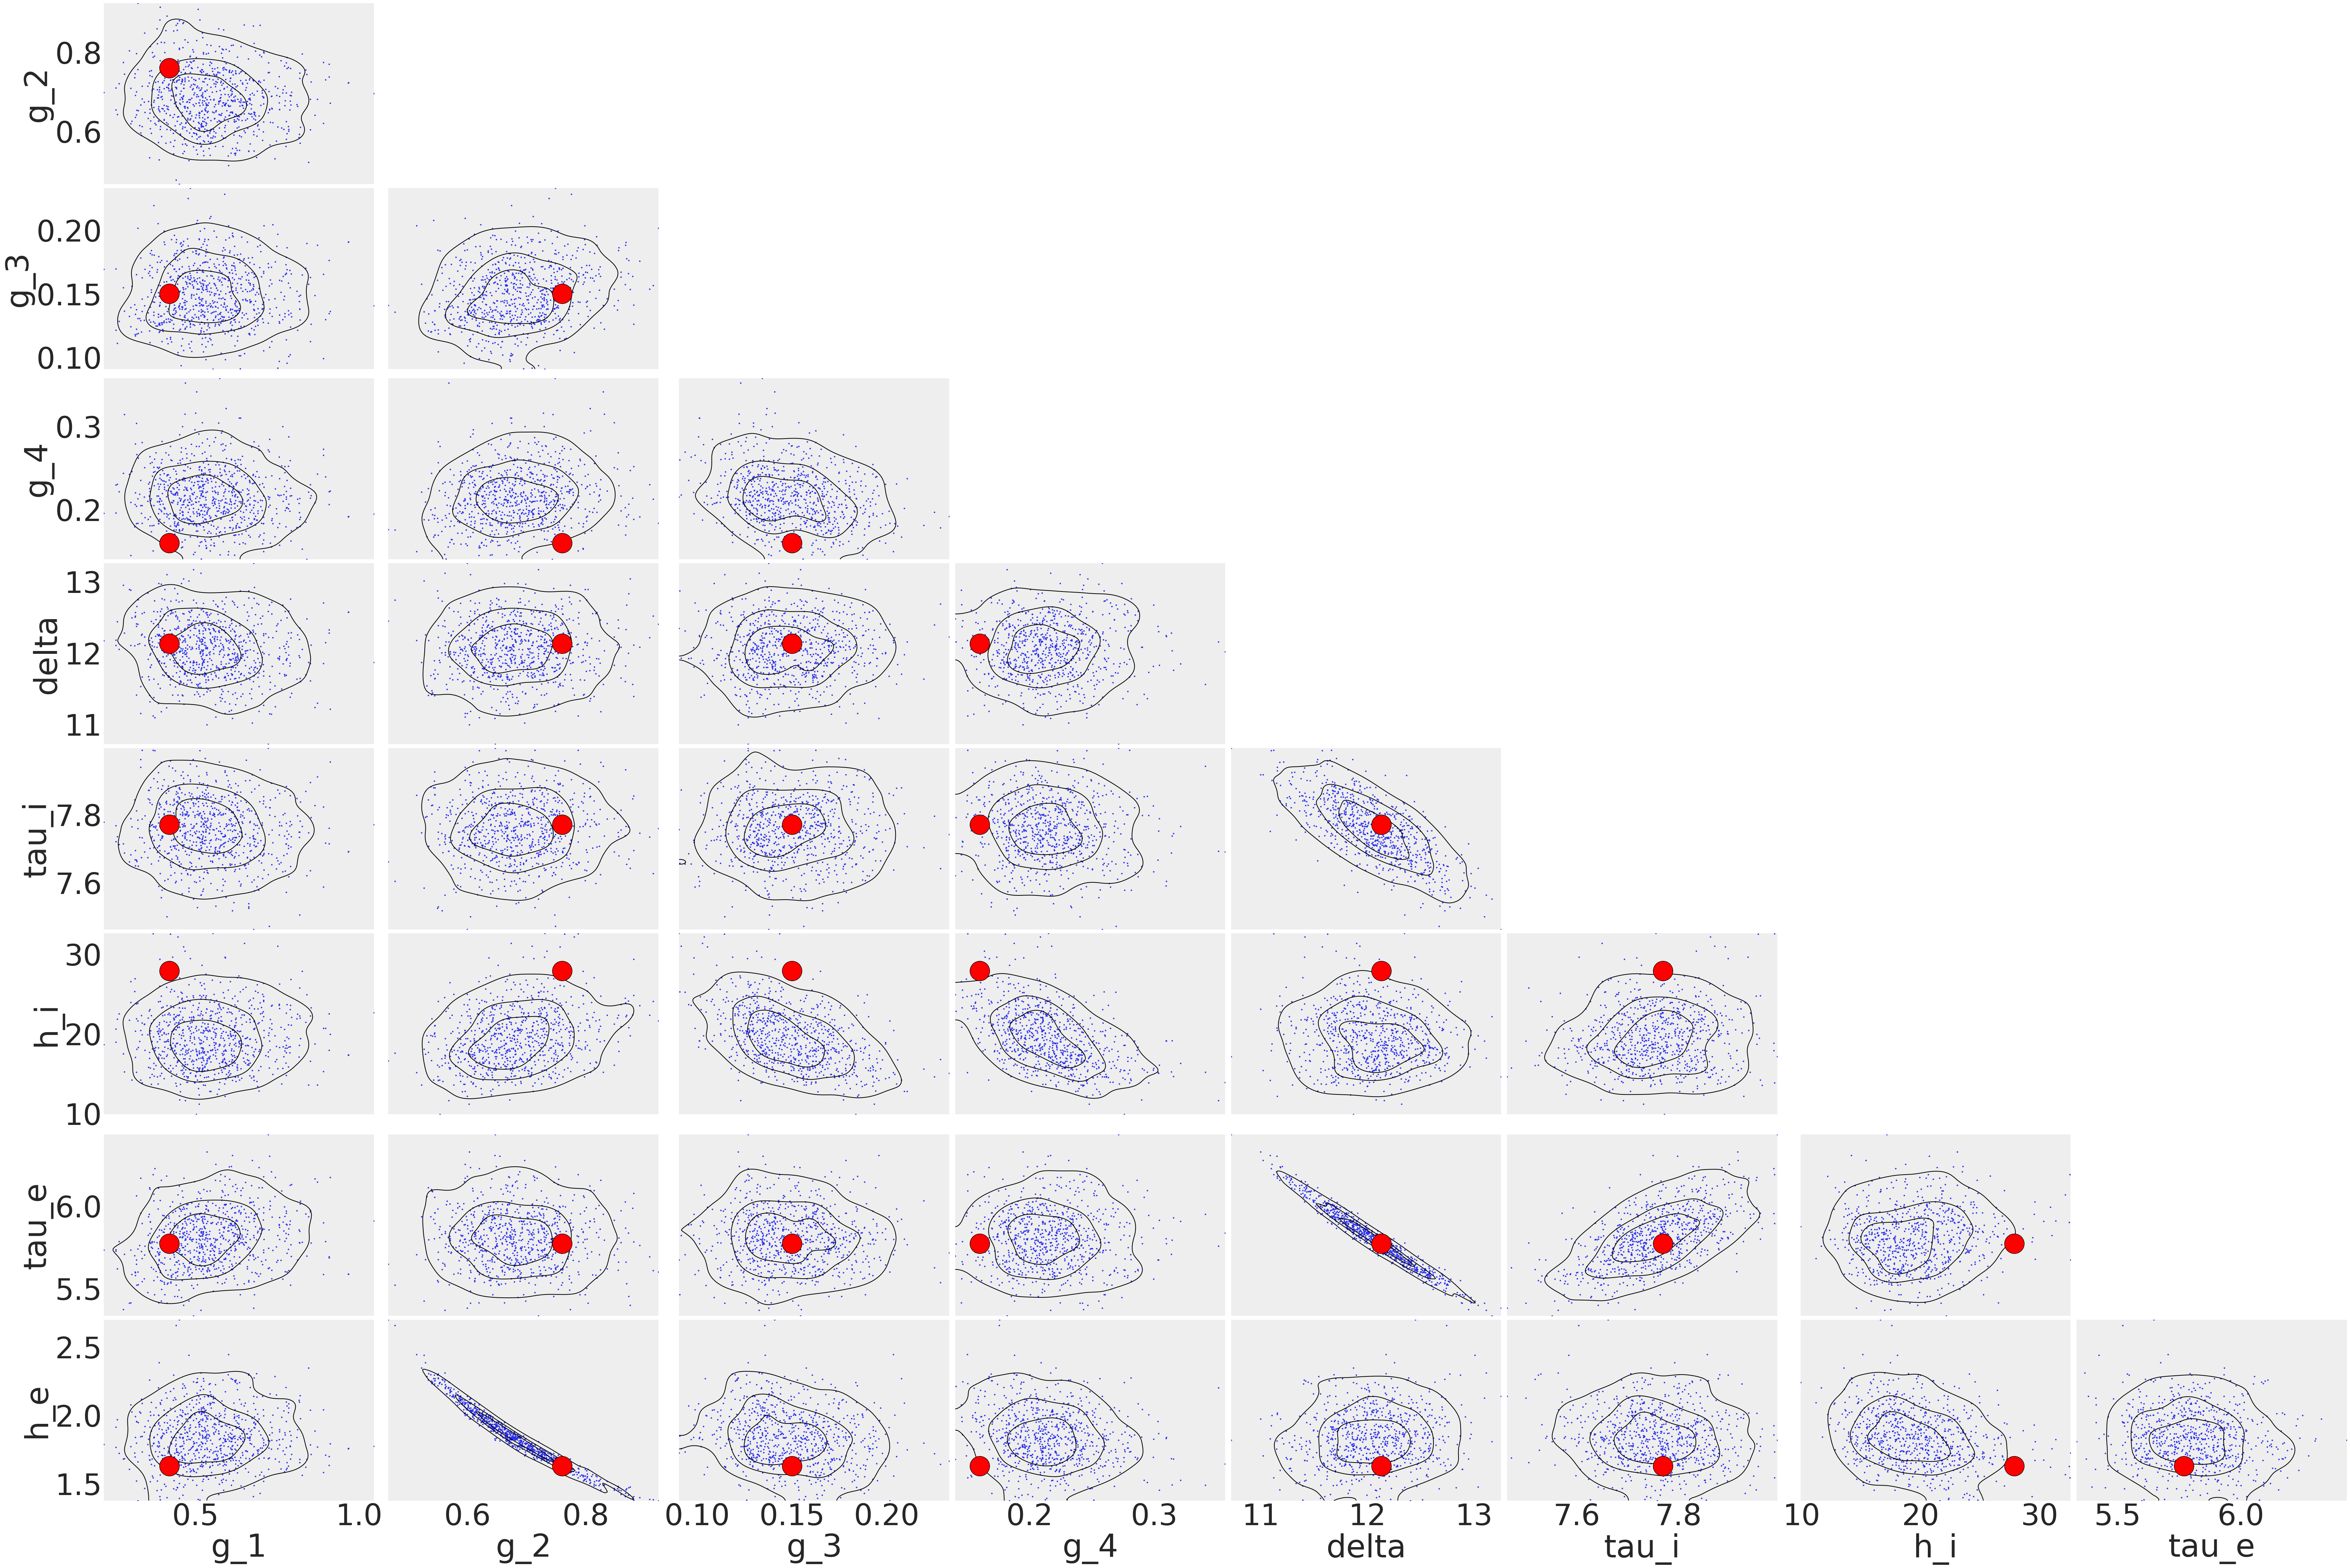

In [97]:
az.plot_pair(az_obj, var_names=my_var_names, 
            kind=["scatter", "kde"], textsize=60, divergences=True,
            kde_kwargs={"fill_last": False,     
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"} },
            reference_values=dict((zip(my_var_names, theta_true))), 
            reference_values_kwargs={'markersize':40, 'color': 'r', 'marker': 'o'}) ;

### Fit and Posterior predictive check of convergenced NUTS

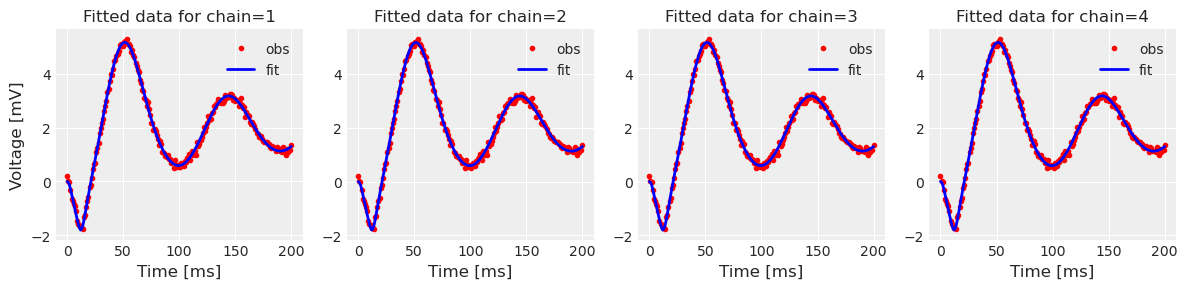

In [98]:
plot_fitted(data, az_obj.posterior)

### Out-of-sample prediction using pooled chains of convergenced NUTS

In [99]:
joint_sample_, ppc_, xpy_per5_, xpy_per95_, x_map_=out_of_samples_ppc_vales(data, ERP_JAXOdeintSimuator, chains_pooled, n_)

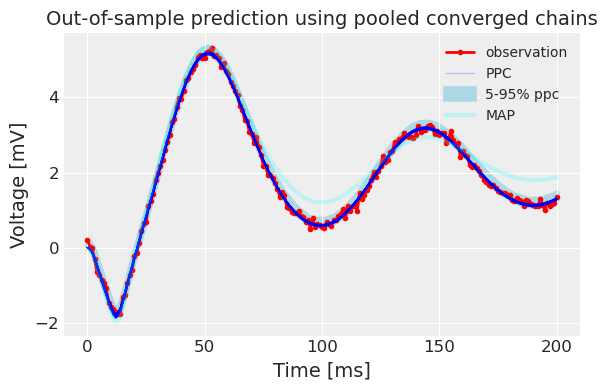

In [100]:
title='Out-of-sample prediction using pooled converged chains'
plot_out_of_sample_ppc_values(data, ERP_JAXOdeintSimuator,joint_sample_, xpy_per5_, xpy_per95_, x_map_, n_, title)

In [101]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Apr 19 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

jax       : 0.4.23
arviz     : 0.17.1
sys       : 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
pathlib   : 1.0.1
seaborn   : 0.12.2
numpy     : 1.24.3
matplotlib: 3.8.0
numpyro   : 0.14.0

Watermark: 2.4.3

